# Carregar as bibliotecas

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from datetime import datetime
from torchvision import datasets, models, transforms
from torchsummary import summary

# Treinamento a partir de uma base propria de imagens

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2024-01-25 16:37:25--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 2607:f8b0:4023:c0d::cf, 2607:f8b0:4023:c06::cf
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   156MB/s    in 0.4s    

2024-01-25 16:37:25 (156 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



## Descompactar arquivo zipado

In [ ]:
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

#### Verificando as pastas geradas

In [ ]:
%ls /tmp/cats_and_dogs_filtered

train/  validation/  vectorize.py


#### Trocar nome da pasta validation para val

In [ ]:
# troca nome
!mv /tmp/cats_and_dogs_filtered/validation /tmp/cats_and_dogs_filtered/val
# visualiza o conteúdo da pasta principal
%ls /tmp/cats_and_dogs_filtered

train/  val/  vectorize.py


## Preparação da base de imagens

<p>
<b>torchvision.datasets.ImageFolder</b>(root: str, transform:  = None, target_transform:  = None, loader:  = <function default_loader>, is_valid_file:  = None)
</p>

Parameters:

<p>
<ul>
    <li>root (string): Root directory path.</li>
    <li>transform (callable, optional): A function/transform that takes in an PIL image and returns a transformed version. E.g, transforms.RandomCrop</li>
    <li>target_transform (callable, optional): A function/transform that takes in the target and transforms it.</li>
    <li>loader (callable, optional): A function to load an image given its path.</li>
    <li>is_valid_file: A function that takes path of an Image file and check if the file is a valid file (used to check of corrupt files)</li>

</ul>
</p>

<p>
A generic data loader where the images are arranged in this way by default:
</p>


```
root
|
-- train
|     |--classe 1
|     |     img1.png
|     |     img2.png
...
|     |--classe n
|     |     img1.png
|     |     img2.png
-- val
|     |--classe 1
|     |     img1.png
|     |     img2.png
...
|     |--classe n
|     |     img1.png
|     |     img2.png
```



#### Definição de parâmetros

In [ ]:
# ROOT, endereço onde está localizada a base de imagens
data_dir = '/tmp/cats_and_dogs_filtered'

# Número de classes do dataset
num_classes = 2

# Tamanho do batch
batch_size = 8


#### Transformações geométricas usadas para realizar aumento de dados e transformar as imagens em tensores pytorch

In [ ]:
# Aumento e normalização de dados para treinamento
# Apenas normalização para validação
input_size = 224
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Inializando Datasets e Dataloaders...")

# Criar conjuntos de dados de treinamento e validação
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

# Criar dataloaders de treinamento e validação
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'val']}

# Detectar a disponibilidade de uma GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Inializando Datasets e Dataloaders...


#### Mostrandos dois exemplos da base de imagens

batch de dados: torch.Size([8, 3, 224, 224])
batch de etiquetas: torch.Size([8])


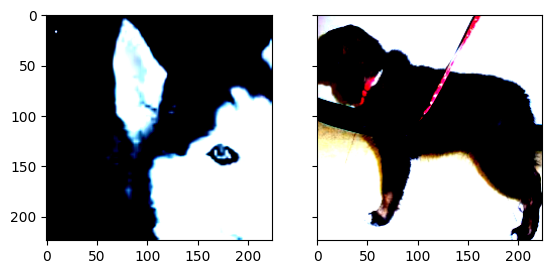

In [ ]:
# verificação do funcionamento do dataloader
for x, y in dataloaders_dict['train']:
    print(f'batch de dados: {x.shape}')
    print(f'batch de etiquetas: {y.shape}')
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    ax1.imshow(np.transpose(x[0].numpy(), (1,2,0)))
    ax2.imshow(np.transpose(x[1].numpy(), (1,2,0)))

    break

# Modelo ResNet

<img src="https://drive.google.com/uc?id=1dLyh_MBQKigMm_z-i_3js4mElD0nm6uZ" alt="Drawing"  width="900"/>

### Carregar a rede ResNet pretreinada com a base ImageNet

In [ ]:
# nova versão
#model_resnet = models.resnet18(weights=models.ResNet18_Weights)
model_resnet = models.resnet18(pretrained=True)
print(model_resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Função para congelar (True) / descongelar (False) os pesos das camadas da rede

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

## Finetuning da rede ResNet:
<p>
<ol>
  <li>Congelar todas as camadas</li>
  <li>Substituir a camada de classificação por uma nova com o mesmo número de neuronios que o número de classes do dataset</li>
</ol>
</p>


### Congelando os pesos da rede ResNet18

In [ ]:
# congela os pesos de todas as camadas da rede
set_parameter_requires_grad(model_resnet, True)
# encontra o número de neurônios na última camada (camada fc)
num_ftrs = model_resnet.fc.in_features
# troca a camada anterior por uma nova camada full connected. A saída da camada é igual ao número de classes de nossa base de imagens
model_resnet.fc = nn.Linear(num_ftrs, num_classes)

In [ ]:
def fit(model, criterion, optimizer, train_loader, test_loader, epochs):
    train_losses = np.zeros( epochs )
    test_losses = np.zeros( epochs )

    for it in range(epochs):
        model.train()
        t0 = datetime.now()
        train_loss = []

        for inputs, targets in train_loader:
            # mover os dados para o GPU
            inputs, targets = inputs.to(device), targets.to(device)

            # zerar os gradientes
            optimizer.zero_grad()

            # forward pass
            outputs = model(inputs)

            loss = criterion(outputs, targets)

            # backward pass e optimiza
            loss.backward()
            optimizer.step()

            train_loss.append( loss.item() )

        train_loss = np.mean(train_loss)

        test_loss = []
        for inputs, targets in test_loader:
            model.eval()
            # mover os dados para o GPU
            inputs, targets = inputs.to(device), targets.to(device)

            # forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        # salvar losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss

        dt = datetime.now() - t0

        print(f'Epoch {it+1}/{epochs} Train Loss: {train_loss:.4f} Test Loss: {test_loss} Duracao: {dt}')

    return train_losses, test_losses

### Função que grafica as funções de perda(custo) do treino e da validação

In [ ]:
def plot_losses(train_losses, test_losses):
    plt.plot(train_losses, label = 'train loss')
    plt.plot(test_losses, label = 'test loss')
    plt.legend()
    plt.show()

### Função que realiza a predição com a rede já treinada

In [ ]:
def predict_module(model, test_loader):
    model.eval()
    predicted = np.empty((0), int)
    true_labels = np.empty((0), int)
    for inputs, targets in test_loader:
        # mover os dados para o GPU
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)

        # obter a predição
        _, predictions = torch.max(outputs, 1)

        predicted = np.append(predicted, predictions.cpu())
        true_labels = np.append(true_labels, targets.cpu())

    return predicted, true_labels

### Função grafica a matriz de confusão como um heatmap

In [ ]:
from sklearn import metrics

In [ ]:
def matriz_confusao(true_labels, predicted, display_labels=['Dog', 'Cat']):
    matriz = metrics.confusion_matrix(true_labels, predicted)
    tot = np.sum(matriz, axis=1, keepdims=True)
    np.set_printoptions(precision=2)
    m_porc = matriz/tot
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=m_porc, display_labels=display_labels)
    disp.plot(values_format='.2f')
    plt.show()

### Treinar a rede

Epoch 1/10 Train Loss: 0.6760 Test Loss: 0.09932001144159586 Duracao: 0:00:23.739610
Epoch 2/10 Train Loss: 0.3500 Test Loss: 0.10251330013657571 Duracao: 0:00:13.913494
Epoch 3/10 Train Loss: 0.3700 Test Loss: 0.07517109075654298 Duracao: 0:00:13.969202
Epoch 4/10 Train Loss: 0.2799 Test Loss: 0.07780532921943814 Duracao: 0:00:13.925618
Epoch 5/10 Train Loss: 0.2535 Test Loss: 0.04714061441132799 Duracao: 0:00:13.951789
Epoch 6/10 Train Loss: 0.2179 Test Loss: 0.06339812122751028 Duracao: 0:00:13.870938
Epoch 7/10 Train Loss: 0.2241 Test Loss: 0.0529090075691347 Duracao: 0:00:16.372715
Epoch 8/10 Train Loss: 0.2016 Test Loss: 0.048755534388823435 Duracao: 0:00:13.955000
Epoch 9/10 Train Loss: 0.2109 Test Loss: 0.0627962315552868 Duracao: 0:00:14.119660
Epoch 10/10 Train Loss: 0.1884 Test Loss: 0.05014273398695514 Duracao: 0:00:14.034535


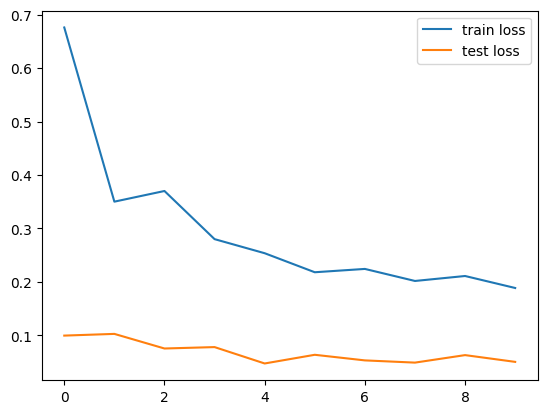

In [ ]:
# treino da rede
model_resnet = model_resnet.to(device)
optimizer_resnet = optim.SGD(model_resnet.parameters(), lr=0.001, momentum=0.9)
criterion_resnet = nn.CrossEntropyLoss()
train_losses, test_losses = fit(model_resnet, criterion_resnet, optimizer_resnet, dataloaders_dict['train'], dataloaders_dict['val'], epochs = 10)
plot_losses(train_losses, test_losses)

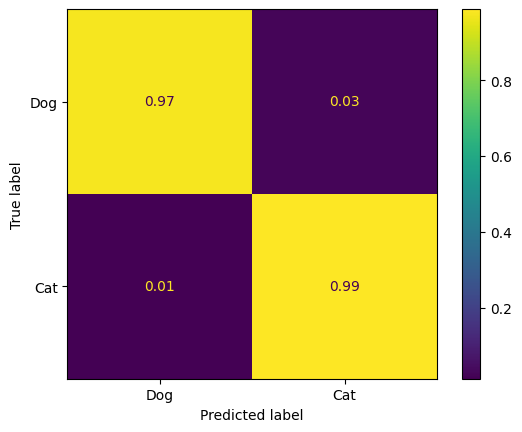

In [ ]:
predicted, true_labels = predict_module(model_resnet, dataloaders_dict['val'])
matriz_confusao(true_labels, predicted)

# Treinar todas as camadas inicializadas com valores aleatórios (from scratch)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/10 Train Loss: 0.7346 Test Loss: 0.7372155747413636 Duracao: 0:00:14.034625
Epoch 2/10 Train Loss: 0.7109 Test Loss: 0.7617031371593476 Duracao: 0:00:14.188599
Epoch 3/10 Train Loss: 0.7070 Test Loss: 0.6561277606487275 Duracao: 0:00:14.000758
Epoch 4/10 Train Loss: 0.7033 Test Loss: 0.8786323275566101 Duracao: 0:00:16.263654
Epoch 5/10 Train Loss: 0.7175 Test Loss: 0.5979924054145813 Duracao: 0:00:16.551645
Epoch 6/10 Train Loss: 0.6874 Test Loss: 0.6207121145725251 Duracao: 0:00:14.189335
Epoch 7/10 Train Loss: 0.6807 Test Loss: 0.6173719464540481 Duracao: 0:00:14.158743
Epoch 8/10 Train Loss: 0.6676 Test Loss: 0.617642212152481 Duracao: 0:00:14.261488
Epoch 9/10 Train Loss: 0.6696 Test Loss: 0.6035332230329513 Duracao: 0:00:14.833049
Epoch 10/10 Train Loss: 0.6685 Test Loss: 0.7684753197431564 Duracao: 0:00:14.078661


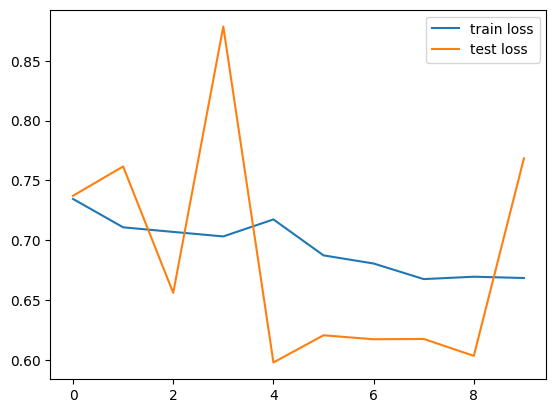

In [ ]:
# carrega a arquitetura
scratch_model = models.resnet18(pretrained=False)
# encontra o número de neurônios na última camada (camada fc)
num_ftrs = scratch_model.fc.in_features
# troca a camada anterior por uma nova camada full connected. A saída da camada é igual ao número de classes de nossa base de imagens
scratch_model.fc = nn.Linear(num_ftrs, num_classes)

scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()

train_losses, test_losses = fit(scratch_model, scratch_criterion, scratch_optimizer, dataloaders_dict['train'], dataloaders_dict['val'], epochs = 10)
plot_losses(train_losses, test_losses)


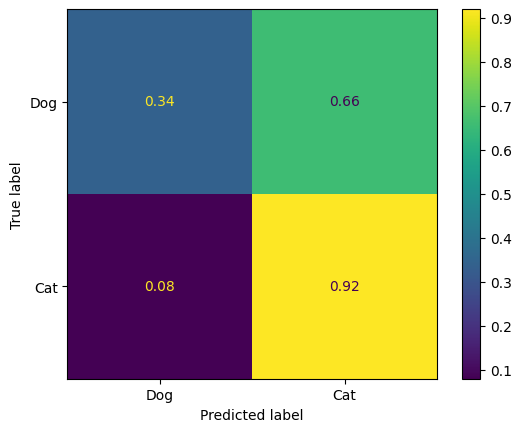

In [ ]:
predicted, true_labels = predict_module(scratch_model, dataloaders_dict['val'])
matriz_confusao(true_labels, predicted)

# Treinar todas as camadas inicializadas com os pesos treinados

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10 Train Loss: 0.3290 Test Loss: 0.07870092407055199 Duracao: 0:00:14.048322
Epoch 2/10 Train Loss: 0.3242 Test Loss: 0.05839162031165324 Duracao: 0:00:14.996211
Epoch 3/10 Train Loss: 0.2392 Test Loss: 0.07164533243514598 Duracao: 0:00:14.275469
Epoch 4/10 Train Loss: 0.2583 Test Loss: 0.05818443136557471 Duracao: 0:00:14.122014
Epoch 5/10 Train Loss: 0.2029 Test Loss: 0.03794077216496226 Duracao: 0:00:14.269035
Epoch 6/10 Train Loss: 0.2156 Test Loss: 0.04231694408287876 Duracao: 0:00:14.113642
Epoch 7/10 Train Loss: 0.2098 Test Loss: 0.0412170469770208 Duracao: 0:00:14.103497
Epoch 8/10 Train Loss: 0.1916 Test Loss: 0.047862189856823535 Duracao: 0:00:14.817014
Epoch 9/10 Train Loss: 0.1974 Test Loss: 0.045844807024346665 Duracao: 0:00:14.231974
Epoch 10/10 Train Loss: 0.2507 Test Loss: 0.0345814303351217 Duracao: 0:00:13.996307


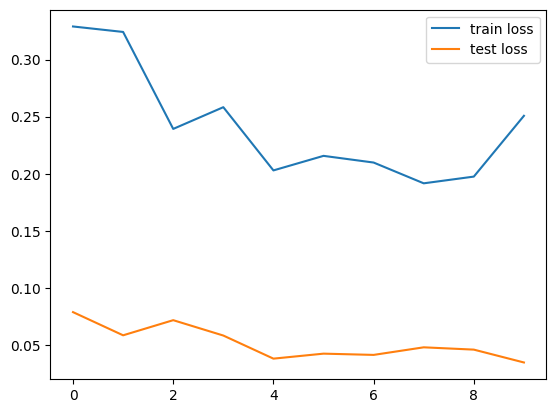

In [ ]:
# carrega a arquitetura
fine1_model = models.resnet18(pretrained=True)
# encontra o número de neurônios na última camada (camada fc)
num_ftrs = scratch_model.fc.in_features
# troca a camada anterior por uma nova camada full connected. A saída da camada é igual ao número de classes de nossa base de imagens
fine1_model.fc = nn.Linear(num_ftrs, num_classes)
fine1_model = fine1_model.to(device)
fine1_optimizer = optim.SGD(fine1_model.parameters(), lr=0.001, momentum=0.9)
fine1_criterion = nn.CrossEntropyLoss()

train_losses, test_losses = fit(fine1_model, fine1_criterion, fine1_optimizer, dataloaders_dict['train'], dataloaders_dict['val'], epochs = 10)
plot_losses(train_losses, test_losses)

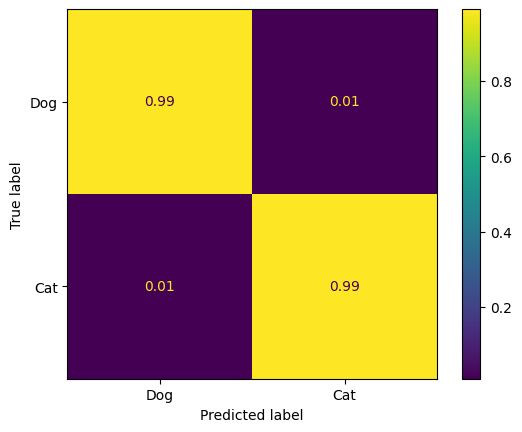

In [ ]:
predicted, true_labels = predict_module(fine1_model, dataloaders_dict['val'])
matriz_confusao(true_labels, predicted)